In [123]:
####################### BLOCK 1: IMPORTS AND UTILITIES #######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def prepare_data(data, selected_features):
    """
    Prepare data for clustering
    
    # Parameters
    data: pandas DataFrame or numpy array
    selected_features: list 
        If DataFrame: column names or indices
        If array: column indices
    """
    if isinstance(data, pd.DataFrame):
        if isinstance(selected_features[0], str):
            X = data[selected_features].values
            feature_names = selected_features
        else:
            X = data.iloc[:, selected_features].values
            feature_names = data.columns[selected_features].tolist()
    else:
        X = data[:, selected_features]
        feature_names = [f"Feature {i}" for i in selected_features]
    
    return X, feature_names

def plot_clusters(X, labels, feature_names, title="Clustering Results", ax=None):
    """Utility function to plot clustering results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}')
    
    ax.set_title(title)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.legend()
    return ax


def plot_clusters_comparison(X, labels, feature_names, color_feature_idx, title="Clustering Results", ax=None):
    """
    Plot clustering results with a color gradient based on a specified feature
    
    Parameters:
    X: array-like of shape (n_samples, n_features)
    labels: cluster labels
    feature_names: list of feature names
    color_feature_idx: index of feature to use for color gradient
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Different markers for different clusters
    markers = ['o', '^', 's', 'D', 'v']  # Add more if needed
    
    # Create scatter plot for each cluster
    for label, marker in zip(unique_labels, markers):
        mask = labels == label
        scatter = ax.scatter(X[mask, 0], 
                           X[mask, 1],
                           c=X[mask, color_feature_idx],
                           marker=marker,
                           label=f'Group {label}',
                           cmap='rainbow',
                           alpha=0.7)
    
    # Add colorbar
    plt.colorbar(scatter, label=feature_names[color_feature_idx])
    
    # Labels and title
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)
    ax.legend()
    
    return ax

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels, method_name, feature_names):
    """Evaluate clustering using multiple metrics"""
    # Skip if all points are noise (-1)
    if all(l == -1 for l in labels):
        print(f"{method_name}: All points classified as noise")
        return
    
    # Calculate metrics (excluding noise points for methods like DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]
    
    if len(np.unique(labels_clean)) > 1:  # Need at least 2 clusters
        sil_score = silhouette_score(X_clean, labels_clean)
        ch_score = calinski_harabasz_score(X_clean, labels_clean)
        db_score = davies_bouldin_score(X_clean, labels_clean)
        
        print(f"\n{method_name} Evaluation:")
        print(f"Silhouette Score: {sil_score:.3f} (higher is better, range: [-1, 1])")
        print(f"Calinski-Harabasz Score: {ch_score:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {db_score:.3f} (lower is better)")
        
        # Calculate cluster properties
        for cluster in np.unique(labels_clean):
            cluster_mask = labels_clean == cluster
            print(f"\nCluster {cluster} statistics:")
            for i, feat in enumerate(feature_names):
                values = X_clean[cluster_mask, i]
                print(f"{feat}: mean = {np.mean(values):.3f}, std = {np.std(values):.3f}")
                
                
def plot_clusters_by_membership(data, labels, plot_features, title="Clustering Results", ax=None):
    """
    Plot clustering results with different colors for each cluster
    
    Parameters:
    -----------
    data : pandas DataFrame
        Complete dataframe containing all features
    labels : array-like
        Cluster labels
    plot_features : tuple or list
        (x_feature_name, y_feature_name) to plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(data[plot_features[0]][mask], 
                  data[plot_features[1]][mask], 
                  c=[color], 
                  label=f'Group {label}',
                  alpha=0.7)
    
    ax.set_xlabel(plot_features[0])
    ax.set_ylabel(plot_features[1])
    ax.set_title(title)
    ax.legend()
    return ax

def plot_clusters_with_dor(data, labels, plot_features, dor_values, title="Clustering Results", ax=None):
    """
    Plot clustering results with discrete DoR groups
    
    Parameters:
    -----------
    data : pandas DataFrame
        Complete dataframe containing all features
    labels : array-like
        Cluster labels
    plot_features : tuple or list
        (x_feature_name, y_feature_name) to plot
    dor_values : array-like
        DoR values for grouping
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create discrete DoR groups
    dor_groups = np.zeros_like(dor_values)
    dor_groups[(dor_values >= 0.3) & (dor_values < 0.6)] = 1
    dor_groups[dor_values >= 0.6] = 2
    
    # Define colors for each group
    colors = ['blue', 'green', 'red']
    labels = ['DoR 0-0.3', 'DoR 0.3-0.6', 'DoR 0.6-1.0']
    
    # Plot each DoR group
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = dor_groups == i
        if np.any(mask):
            ax.scatter(data[plot_features[0]][mask],
                      data[plot_features[1]][mask],
                      c=color,
                      label=label,
                      alpha=0.7)
    
    ax.set_xlabel(plot_features[0])
    ax.set_ylabel(plot_features[1])
    ax.set_title(title)
    ax.legend()
    return ax

In [124]:
####################### BLOCK 2: K-MEANS #######################
def kmeans_clustering(data, selected_features, n_clusters=3):
    """
    Perform K-Means clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Elbow method
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "K-Means Clustering")
    #plt.show()
    
    return kmeans, labels

In [125]:
####################### BLOCK 3: DBSCAN #######################
def dbscan_clustering(data, selected_features, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering
    
    # Note: Number of clusters is determined automatically
    # Can estimate eps using nearest neighbors plot
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # #plot results
    #plot_clusters(X, labels, feature_names, "DBSCAN Clustering")
    #plt.show()
    
    return dbscan, labels

In [126]:
####################### BLOCK 4: MEAN SHIFT #######################
def meanshift_clustering(data, selected_features):
    """
    Perform Mean-Shift clustering
    
    # Note: Number of clusters is determined automatically
    # based on the data density
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Mean-Shift
    ms = MeanShift(bandwidth=2)
    labels = ms.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Mean-Shift Clustering")
    #plt.show()
    
    return ms, labels

In [127]:
def gmm_clustering(data, selected_features, n_components=3):
    """
    Perform Gaussian Mixture clustering
    
    # Note: Can determine optimal n_components using:
    # - BIC (Bayesian Information Criterion)
    # - AIC (Akaike Information Criterion)
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Gaussian Mixture Clustering")
    #plt.show()
    
    return gmm, labels

In [128]:

####################### BLOCK 6: HIERARCHICAL #######################
def hierarchical_clustering(data, selected_features, n_clusters=3):
    """
    Perform Hierarchical clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Dendrogram analysis
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Hierarchical Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hc.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Hierarchical Clustering")
    #plt.show()
    
    return hc, labels

In [129]:
####################### BLOCK 7: USAGE EXAMPLES #######################
df = pd.read_csv('data/E-INSPIRE_I_master_catalogue.csv')
df = df.sample(frac=1).reset_index(drop=True)

print("Available features:", df.columns.tolist())

# Select features for clustering
# Example using column names
selected_features = ['age_mean_mass', '[M/H]_mean_mass',  'velDisp_ppxf_res', 'MgFe']
dor_values = df['DoR'].values  # Get DoR separately for coloring
# OR using column indices
# selected_features = [0, 1, 2]

# 1. K-Means Example
print("\n=== K-Means Clustering ===")
# Try different numbers of clusters
for n_clusters in [2, 3, 4]:
    kmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=n_clusters)
    # Count samples in each cluster
    unique, counts = np.unique(kmeans_labels, return_counts=True)
    print(f"K-Means with {n_clusters} clusters:")
    print(dict(zip(unique, counts)))

# 2. DBSCAN Example
print("\n=== DBSCAN Clustering ===")
# Try different eps values
for eps in [0.3, 0.5, 0.7]:
    dbscan_model, dbscan_labels = dbscan_clustering(df, selected_features, 
                                                  eps=eps, 
                                                  min_samples=5)
    # Count samples in each cluster (-1 is noise)
    unique, counts = np.unique(dbscan_labels, return_counts=True)
    print(f"\nDBSCAN with eps={eps}:")
    print(dict(zip(unique, counts)))
    print(f"Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

# 3. Mean-Shift Example
print("\n=== Mean-Shift Clustering ===")
ms_model, ms_labels = meanshift_clustering(df, selected_features)
# Count samples in each cluster
unique, counts = np.unique(ms_labels, return_counts=True)
print("Mean-Shift clusters:")
print(dict(zip(unique, counts)))
print(f"Number of clusters found: {len(unique)}")

# 4. Gaussian Mixture Example
print("\n=== Gaussian Mixture Clustering ===")
# Try different numbers of components
for n_components in [2, 3, 4]:
    gmm_model, gmm_labels = gmm_clustering(df, selected_features, 
                                         n_components=n_components)
    # Count samples in each cluster
    unique, counts = np.unique(gmm_labels, return_counts=True)
    print(f"\nGMM with {n_components} components:")
    print(dict(zip(unique, counts)))
    
    # Calculate BIC score correctly
    X, _ = prepare_data(df, selected_features)
    X_scaled = StandardScaler().fit_transform(X)
    print(f"BIC Score: {gmm_model.bic(X_scaled)}")

# 5. Hierarchical Clustering Example
print("\n=== Hierarchical Clustering ===")
# Try different numbers of clusters
for n_clusters in [2, 3, 4]:
    hc_model, hc_labels = hierarchical_clustering(df, selected_features, 
                                                n_clusters=n_clusters)
    # Count samples in each cluster
    unique, counts = np.unique(hc_labels, return_counts=True)
    print(f"\nHierarchical with {n_clusters} clusters:")
    print(dict(zip(unique, counts)))

Available features: ['GALAXY ID', 'ra', 'dec', 'plate', 'mjd', 'fiberid', 'objid', 'deVRad_r', 'deVRadErr_r', 'expRad_r', 'expRadErr_r', 'z', 'zErr', 'SNR', 'velDisp_SDSS', 'velDispErr_SDSS', 'velDisp_ppxf_full', 'velDisp_ppxf_err_full', 'velDisp_ppxf_res', 'velDisp_ppxf_err_res', 'logM*', 'errlogM*', 'logSFR', 'errlogSFR', 'logsSFR', 'errlogsSFR', 'petroR50Errkpc_r', 'petroR50kpc_r', 'deVRadkpc_r', 'deVRadErrkpc_r', 'expRadkpc_r', 'expRadErrkpc_r', 'fracDev_r', 'meanRad_r', 'meanRadErr_r', 'meanRadkpc_r', 'meanRadErrkpc_r', 'meanRad_kids', 'meanRadkpc_kids', 'Mgb_ssp', 'Fe_avg_ssp', 'Mgb_sigmacorr', 'Fe_avg_sigmacorr', 'MgFe', 'alphaFe_flag', 'univ_age', 'age_mean_mass', 'age_err_mass', 'age_mean_light', 'age_err_light', '[M/H]_mean_mass', '[M/H]_err_mass', '[M/H]_mean_light', '[M/H]_err_light', 'Mtbb3', 'Mtbb3_unr', 'Mtbb3_reg', 'Mtbb3_alphaplus', 'Mtbb3_alphamin', 't_75', 't_75_unr', 't_75_reg', 't_75_alphaplus', 't_75_alphamin', 't_90', 't_90_unr', 't_90_reg', 't_90_alphaplus', 't_

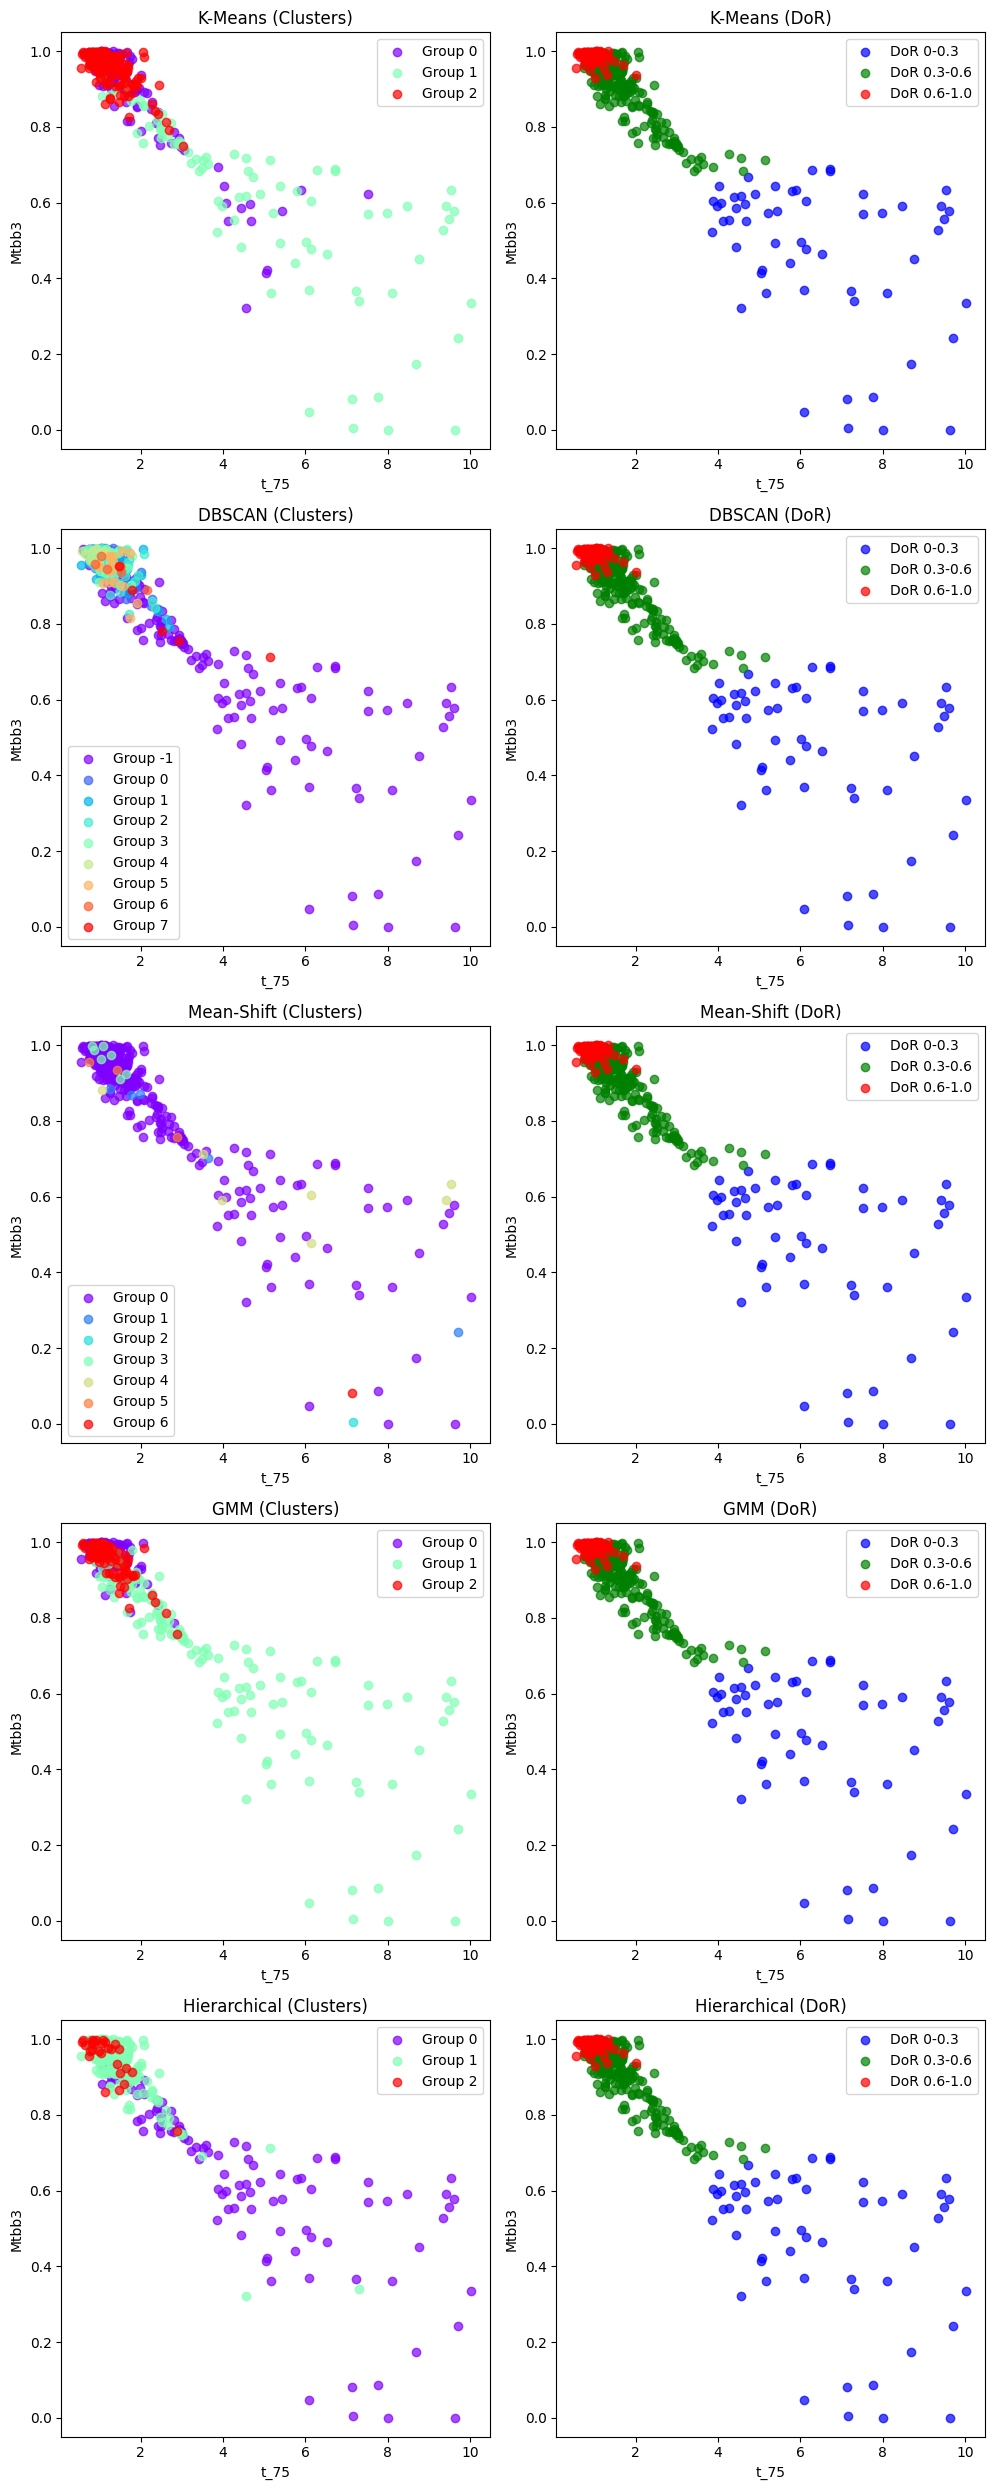

In [130]:
# Create two sets of subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(15, 25))

# Define your clustering features and plotting features
clustering_features = ['MgFe', 'age_mean_mass', '[M/H]_mean_mass', 'velDisp_ppxf_res']
plot_features = ('age_mean_mass','[M/H]_mean_mass')  # Change these to whatever you want to plot
plot_features = ('t_75','Mtbb3')  # Change these to whatever you want to plot

"""select from ['GALAXY ID', 'ra', 'dec', 'plate', 'mjd', 'fiberid', 'objid', 'deVRad_r', 'deVRadErr_r', 'expRad_r', 'expRadErr_r', 'z', 'zErr', 'SNR', 'velDisp_SDSS', 'velDispErr_SDSS', 'velDisp_ppxf_full', 'velDisp_ppxf_err_full', 'velDisp_ppxf_res', 'velDisp_ppxf_err_res', 'logM*', 'errlogM*', 'logSFR', 'errlogSFR', 'logsSFR', 'errlogsSFR', 'petroR50Errkpc_r', 'petroR50kpc_r', 'deVRadkpc_r', 'deVRadErrkpc_r', 'expRadkpc_r', 'expRadErrkpc_r', 'fracDev_r', 'meanRad_r', 'meanRadErr_r', 'meanRadkpc_r', 'meanRadErrkpc_r', 'meanRad_kids', 'meanRadkpc_kids', 'Mgb_ssp', 'Fe_avg_ssp', 'Mgb_sigmacorr', 'Fe_avg_sigmacorr', 'MgFe', 'alphaFe_flag', 'univ_age', 'age_mean_mass', 'age_err_mass', 'age_mean_light', 'age_err_light', '[M/H]_mean_mass', '[M/H]_err_mass', '[M/H]_mean_light', '[M/H]_err_light', 'Mtbb3', 'Mtbb3_unr', 'Mtbb3_reg', 'Mtbb3_alphaplus', 'Mtbb3_alphamin', 't_75', 't_75_unr', 't_75_reg', 't_75_alphaplus', 't_75_alphamin', 't_90', 't_90_unr', 't_90_reg', 't_90_alphaplus', 't_90_alphamin', 't_100', 't_100_unr', 't_100_reg', 't_100_alphaplus', 't_100_alphamin', 'DoR']"""

# Prepare data for clustering
X = df[clustering_features].values
X_scaled = StandardScaler().fit_transform(X)

# First row: K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
plot_clusters_by_membership(df, kmeans_labels, plot_features, "K-Means (Clusters)", ax1)
plot_clusters_with_dor(df, kmeans_labels, plot_features, df['DoR'].values, "K-Means (DoR)", ax2)
ax3.set_visible(False)

# Second row: DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
plot_clusters_by_membership(df, dbscan_labels, plot_features, "DBSCAN (Clusters)", ax4)
plot_clusters_with_dor(df, dbscan_labels, plot_features, df['DoR'].values, "DBSCAN (DoR)", ax5)
ax6.set_visible(False)

# Third row: Mean-Shift
ms = MeanShift(bandwidth=2)
ms_labels = ms.fit_predict(X_scaled)
plot_clusters_by_membership(df, ms_labels, plot_features, "Mean-Shift (Clusters)", ax7)
plot_clusters_with_dor(df, ms_labels, plot_features, df['DoR'].values, "Mean-Shift (DoR)", ax8)
ax9.set_visible(False)

# Fourth row: GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
plot_clusters_by_membership(df, gmm_labels, plot_features, "GMM (Clusters)", ax10)
plot_clusters_with_dor(df, gmm_labels, plot_features, df['DoR'].values, "GMM (DoR)", ax11)
ax12.set_visible(False)

# Fifth row: Hierarchical
hc = AgglomerativeClustering(n_clusters=3)
hc_labels = hc.fit_predict(X_scaled)
plot_clusters_by_membership(df, hc_labels, plot_features, "Hierarchical (Clusters)", ax13)
plot_clusters_with_dor(df, hc_labels, plot_features, df['DoR'].values, "Hierarchical (DoR)", ax14)
ax15.set_visible(False)

plt.tight_layout()
plt.show()



In [131]:

# Evaluate all methods
print("\n=== Clustering Evaluation ===")
methods = {
   "K-Means": kmeans_labels,
   "DBSCAN": dbscan_labels,
   "Mean-Shift": ms_labels,
   "GMM": gmm_labels,
   "Hierarchical": hc_labels
}

for method_name, labels in methods.items():
   evaluate_clustering(X_scaled, labels, method_name, clustering_features)
   print("\n" + "="*50 + "\n")  # Separator between methods


# Print summary statistics
print("\nSummary of Results:")
methods = {
    "K-Means": kmeans_labels,
    "DBSCAN": dbscan_labels,
    "Mean-Shift": ms_labels,
    "GMM": gmm_labels,
    "Hierarchical": hc_labels
}

for method_name, labels in methods.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"\n{method_name}:")
    print(f"Number of clusters: {n_clusters}")
    print("Cluster sizes:", dict(zip(range(n_clusters), 
          np.bincount(labels[labels >= 0]))))


=== Clustering Evaluation ===

K-Means Evaluation:
Silhouette Score: 0.267 (higher is better, range: [-1, 1])
Calinski-Harabasz Score: 162.632 (higher is better)
Davies-Bouldin Score: 1.300 (lower is better)

Cluster 0 statistics:
MgFe: mean = -0.747, std = 0.567
age_mean_mass: mean = 0.301, std = 0.584
[M/H]_mean_mass: mean = 0.353, std = 0.470
velDisp_ppxf_res: mean = 0.042, std = 0.865

Cluster 1 statistics:
MgFe: mean = -0.301, std = 1.085
age_mean_mass: mean = -1.597, std = 0.876
[M/H]_mean_mass: mean = -1.334, std = 1.321
velDisp_ppxf_res: mean = -0.480, std = 0.753

Cluster 2 statistics:
MgFe: mean = 0.917, std = 0.384
age_mean_mass: mean = 0.500, std = 0.399
[M/H]_mean_mass: mean = 0.313, std = 0.542
velDisp_ppxf_res: mean = 0.199, std = 1.148



DBSCAN Evaluation:
Silhouette Score: 0.190 (higher is better, range: [-1, 1])
Calinski-Harabasz Score: 71.841 (higher is better)
Davies-Bouldin Score: 1.321 (lower is better)

Cluster 0 statistics:
MgFe: mean = -0.207, std = 0.000
age